# Idea
* Draw a high-resolution image of the network
  * Make sure each railway station has a unique color
  * Make sure the station nodes "cut" the railway line edges
  * Don't draw non-station nodes
* Use the image to construct a graph
  * Recover node attributes using node colors

In [1]:
import osmnx as ox

ox.config(log_console = True, data_folder = 'data')
graph = ox.load_graphml('northeuroperails_alt.graphml')

{'crs': '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs', 'name': 'unnamed'}


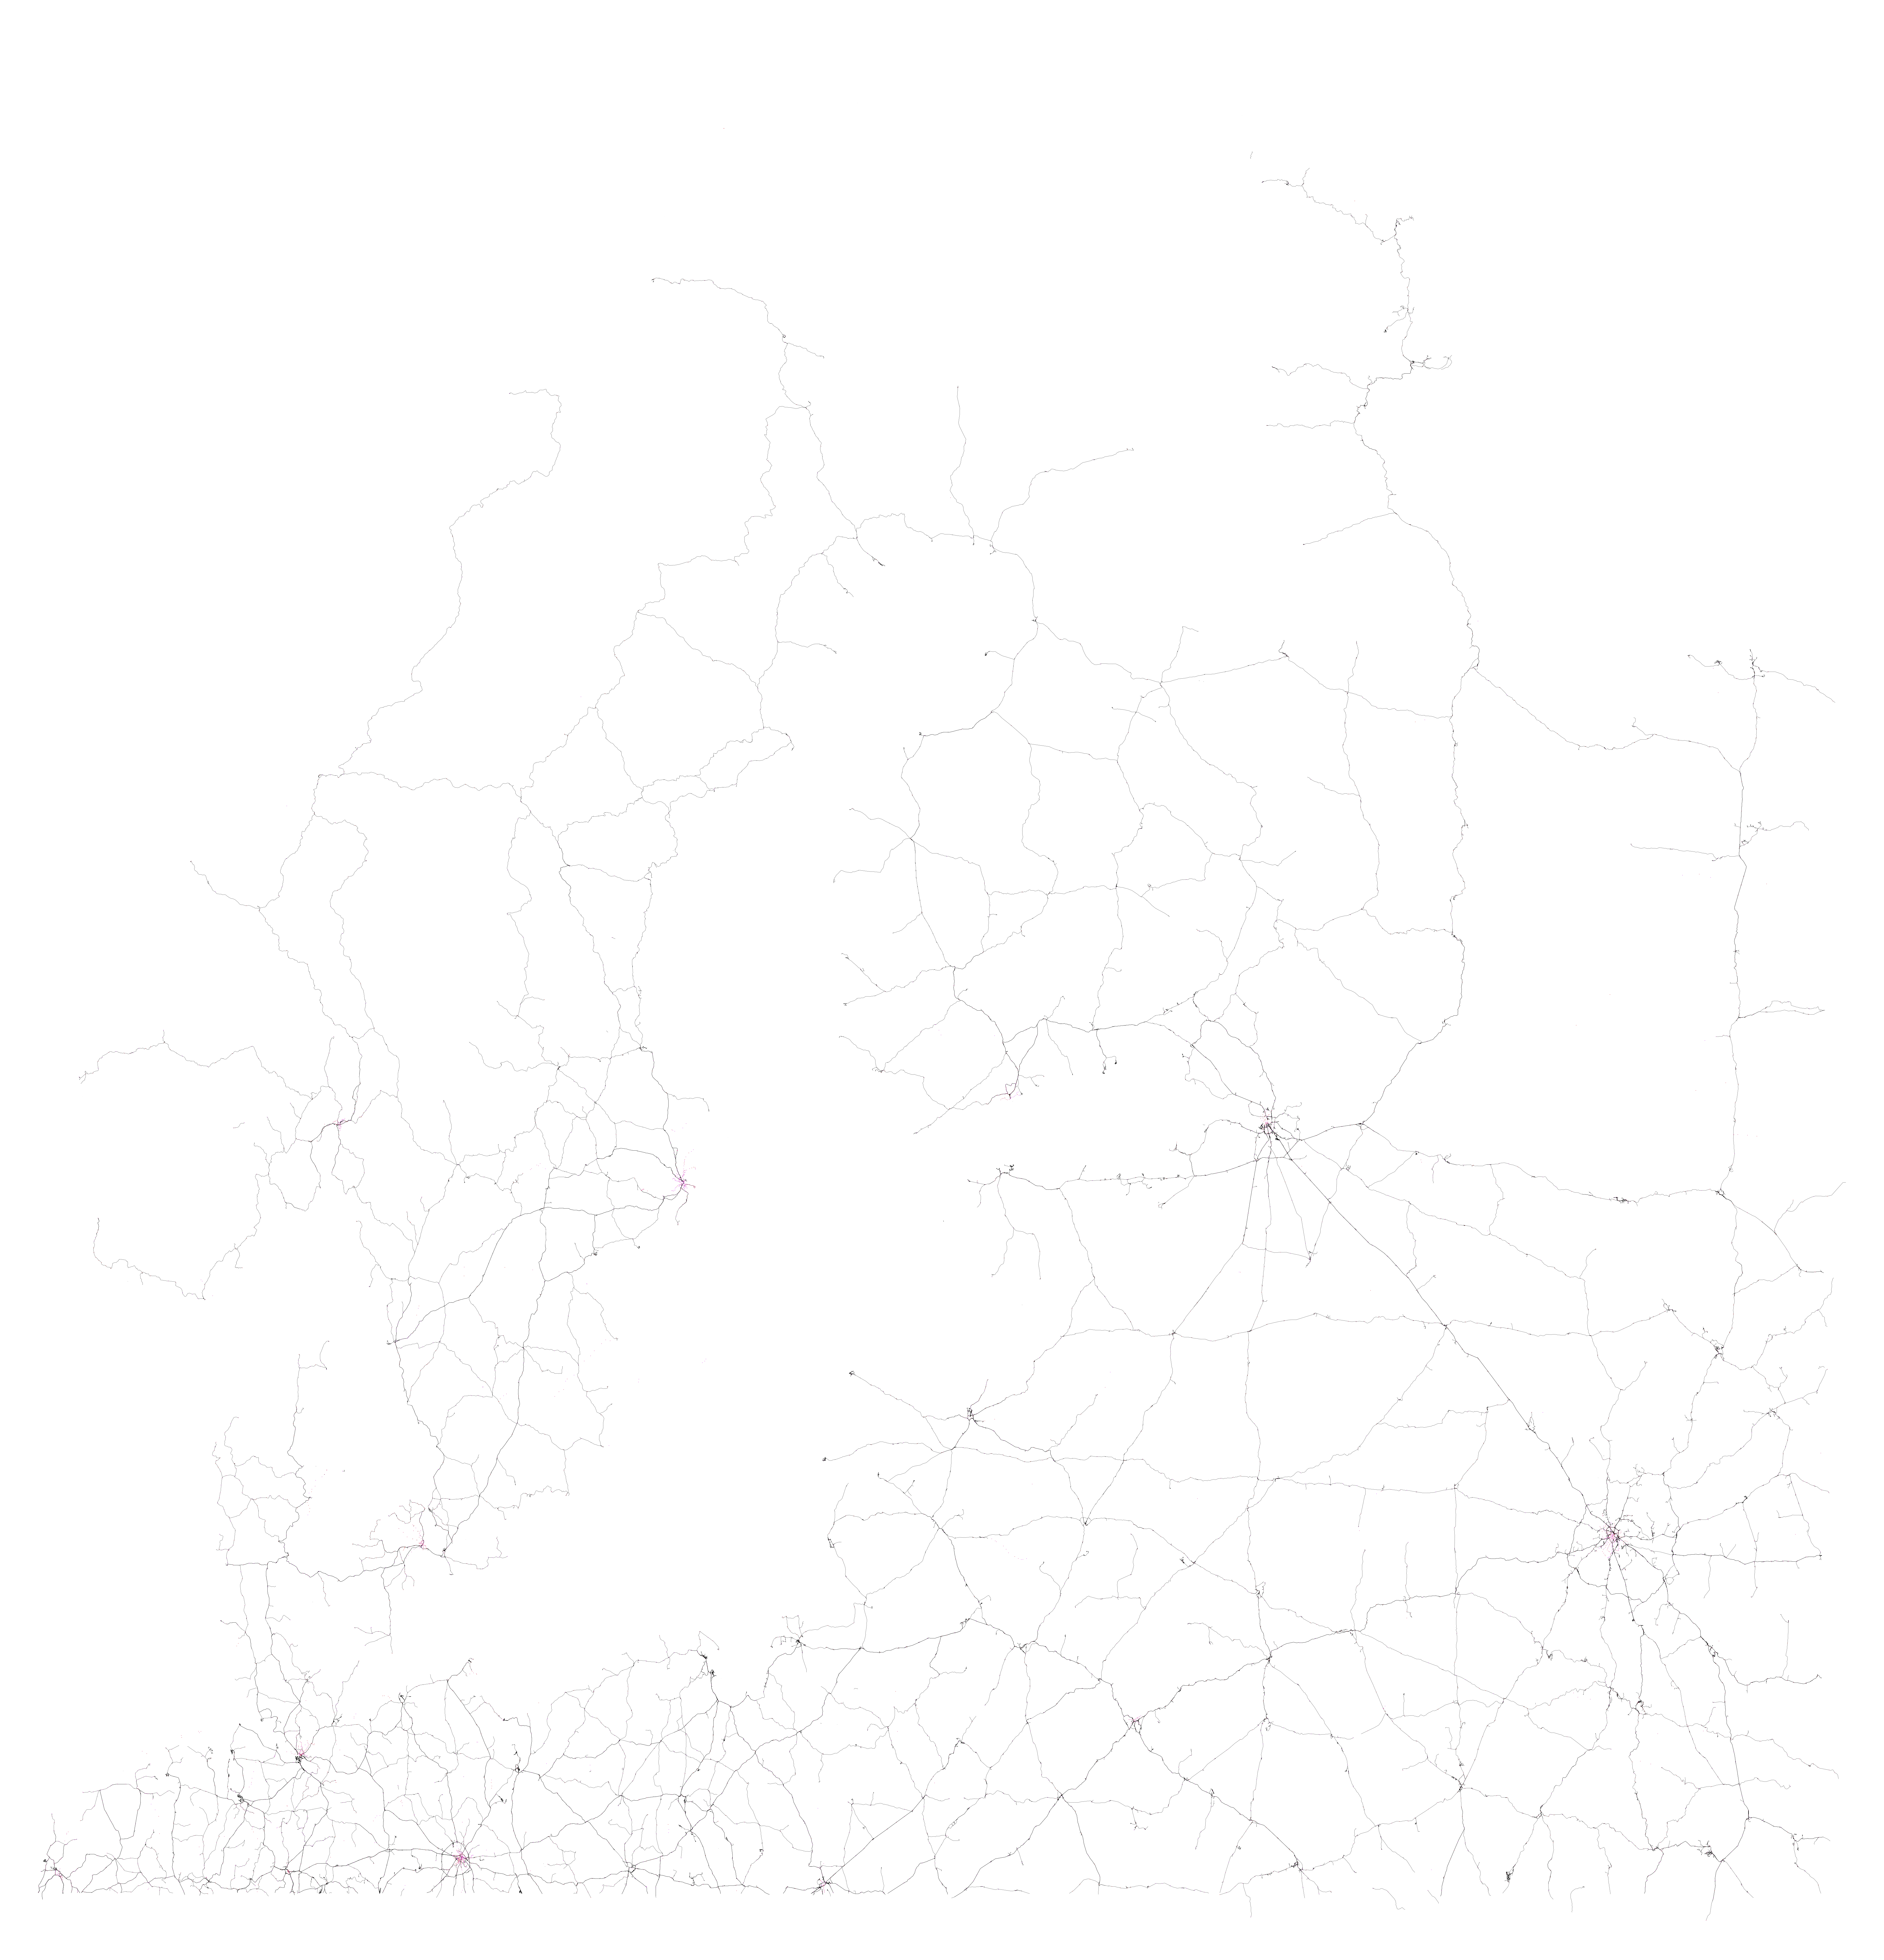

(<Figure size 18483.7x9216 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe813056be0>)

In [2]:
def iter_colors(start):
    '''
    Iterator that returns unique HTML colors in a sequence,
    starting from the given (r, g, b) start color
    '''
    r, g, b = start
    while r < 256:
        yield f'#{r:02x}{g:02x}{b:02x}'
        b += 1
        if r == g and g == b:
            b += 1
        if b > 255:
            b = 0
            g += 1
        if g > 255:
            g = 0
            r += 1

coloriterator = iter_colors((200, 0, 0))
node_colors = []
color_to_station = {}
for n in graph.nodes.values():
    if 'railway' in n and n['railway'] == 'station':
        color = next(coloriterator)
        node_colors.append(color)
        color_to_station[color] = n
    else: node_colors.append('#000000')
# Set the size of non-railway nodes to 0 in order to not draw them
node_sizes = [2 if 'railway' in n and n['railway'] == 'station' else 0 for n in graph.nodes.values()]

ox.plot_graph(graph,
              fig_height=128,
              node_color = node_colors, edge_color='#000000',
              node_size = node_sizes, edge_linewidth=.25, node_zorder=3,
              save=True, filename='fig' # Gets saved as images/fig.png
            )

In [3]:
import re
import imageio as imgio
from PIL import Image
import numpy as np
import networkx as nx
from itertools import combinations

Image.MAX_IMAGE_PIXELS = None # Needed to load our huge image
HTML_COLOR_RE = re.compile(r'#([0-9a-f]{2})([0-9a-f]{2})([0-9a-f]{2})')

def color_to_html(color):
    r, g, b = color
    return f'#{r:02x}{g:02x}{b:02x}'

def html_to_color(html):
    return [int(group, base=16) for group in HTML_COLOR_RE.match(html).groups()]

def is_monochrome(color):
    return color[0] == color[1] and color[1] == color[2]

def is_way(color):
    return is_monochrome(color) and np.sum(color) < 512 # 512 is a magic number with which this just works : - D

def consume_node(img, history, startx, starty):
    '''
    Consumes a node starting at [startx, starty] by reading non-monochrome pixels around it
    and turning them white until there are none left.
    Also picks up ways surrounding the node.
    The node color is decided by a vote - the most used color is picked as the node color.
    '''
    if is_monochrome(img[startx, starty]):
        return None, []
    to_consume = [(startx, starty)]
    consumed = []
    new_ways = []
    colors = {}
    while to_consume:
        nxt = to_consume.pop()
        if is_monochrome(img[nxt[0], nxt[1]]):
            continue # Already white -> ignore
        color = img[nxt[0], nxt[1]]
        ckey = color_to_html(color) # Keep track of found colors
        if ckey not in colors:
            colors[ckey] = 0
        colors[ckey] += 1
        img[nxt[0], nxt[1]] = [255, 255, 255] # Paint the current pixel white in order to not revisit it
        consumed.append(nxt)
        for d in ((0, 1), (1, 0), (0, -1), (-1, 0)): # Check the surroundings of the current pixel
            candidate = (nxt[0] + d[0], nxt[1] + d[1])
            if not is_monochrome(img[candidate[0], candidate[1]]): # Not monochrome -> part of a node
                to_consume.append(candidate)
            elif is_way(img[candidate[0], candidate[1]]):
                new_ways.append(candidate)
    node_color = max(colors, key=lambda c: colors[c])
    color_arr = html_to_color(node_color)
    for c in consumed:
        history[c[0], c[1], :] = color_arr
    return node_color, new_ways

def consume_way(img, history, startx, starty):
    '''
    Consumes a way starting at [startx, starty] by reading dark, monochrome pixels around it
    and turning them white until there are none left.
    Also picks up nodes the way leads to.
    '''
    if not is_way(img[startx, starty]):
        return [], []
    to_consume = [(startx, starty)]
    new_nodes = []
    new_connections = []
    while to_consume:
        nxt = to_consume.pop()
        if is_monochrome(img[nxt[0], nxt[1]]) and not is_way(img[nxt[0], nxt[1]]):
            continue # Already white -> ignore
        img[nxt[0], nxt[1]] = [255, 255, 255] # Paint the current pixel white in order to not revisit it
        for d in ((0, 1), (1, 0), (0, -1), (-1, 0)): # Check the surroundings of the current pixel
            candidate = (nxt[0] + d[0], nxt[1] + d[1])
            if is_way(img[candidate[0], candidate[1]]):
                to_consume.append(candidate)
            elif not is_monochrome(img[candidate[0], candidate[1]]): # Not monochrome -> part of a node
                new_nodes.append(candidate)
            elif not is_monochrome(history[candidate[0], candidate[1]]):
                new_connections.append(color_to_html(history[candidate[0], candidate[1]]))
    return new_nodes, new_connections

def build_network(img_file, startx, starty):
    '''
    Consumes ways and nodes in the image, starting at the node in [startx, starty],
    and builds a network based on them
    '''
    img = imgio.imread(img_file)[:, :, :3] # Keep only r, g, b (drop a)
    history = np.zeros(img.shape, dtype=np.uint8)
    nodes_to_consume = [(None, startx, starty)]
    ways_to_consume = []
    missed_connections = []
    g = nx.Graph()
    while nodes_to_consume or ways_to_consume:
        if nodes_to_consume:
            frm, x, y = nodes_to_consume.pop()
            node, ways = consume_node(img, history, x, y)
            if node is not None:
                g.add_node(node)
                if frm is not None:
                    for f in frm: g.add_edge(f, node)
                ways_to_consume.extend([(node, *way) for way in ways])
        if ways_to_consume:
            frm, x, y = ways_to_consume.pop()
            nodes, connections = consume_way(img, history, x, y)
            if len(nodes) > 1: missed_connections.extend(combinations(nodes, 2))
            nodes_to_consume.extend([([frm, *connections], *node) for node in nodes])
            for c in connections:
                g.add_edge(frm, c)
    for p1, p2 in missed_connections:
        key1 = color_to_html(history[p1[0], p1[1]])
        key2 = color_to_html(history[p2[0], p2[1]])
        g.add_edge(key1, key2)
    return g

net = build_network('images/fig.png', 16256, 14942) # Helsinki railway station is at 16256, 14942

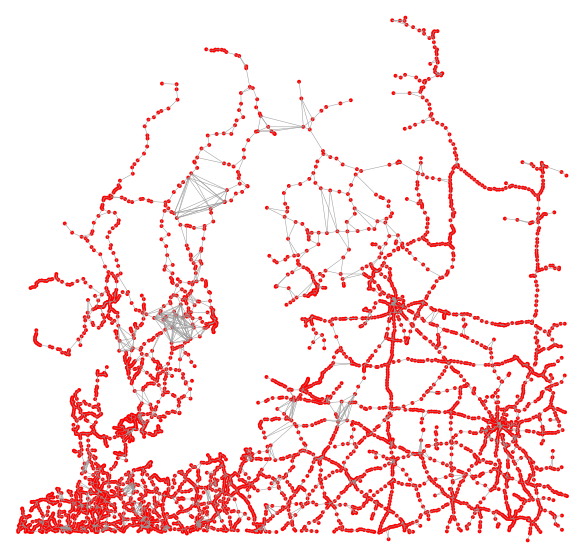

(<Figure size 1544.57x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe85e479670>)

In [23]:
nx.set_node_attributes(net, color_to_station)
#nx.draw(net, node_size=10)
net = nx.MultiGraph(net)
net.graph['crs'] = graph.graph['crs']
net.graph['name'] = graph.graph['name']
ox.plot_graph(net, fig_height=10, node_color = 'r', edge_linewidth=.5)

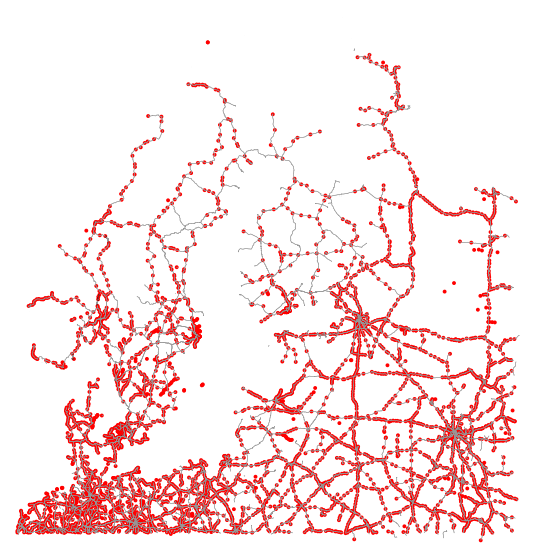

(<Figure size 1444.04x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe824d01df0>)

In [24]:
node_sizes = [15 if 'railway' in n and n['railway'] == 'station' else 0 for n in graph.nodes.values()]
ox.plot_graph(graph, fig_height=10, node_color = 'r', node_size = node_sizes, edge_linewidth=.5)

In [28]:
import haversine as hvs

for frm, to, key in net.edges:
    x1, y1 = net.nodes[frm]['x'], net.nodes[frm]['y']
    x2, y2 = net.nodes[to]['x'], net.nodes[to]['y']
    length = hvs.haversine((y1, x1), (y2, x2))
    net.edges[frm, to, key]['length'] = length
    net.edges[frm, to, key]['oneway'] = False # Should always be in networkx MultiGraph

In [29]:
mapping = {}
for n in net.nodes.data():
    mapping.update({ n[0] : n[1]['osmid'] })
nx.relabel_nodes(net, mapping, copy=False)

In [30]:
ox.save_graphml(net, 'nerails_simplified.graphml')